# Assumptions:
1. Assuming this data portion used to train the model is representative of the actual real life data


In [8]:
import pandas as pd

# load data from csv
data_path = "./Data/bank-full.csv"
df = pd.read_csv(data_path, delimiter=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Data visualisation using histograms
### Visually analasying these histograms provides us with quick overview that may help us make better decisions as to how to handle the data onward.

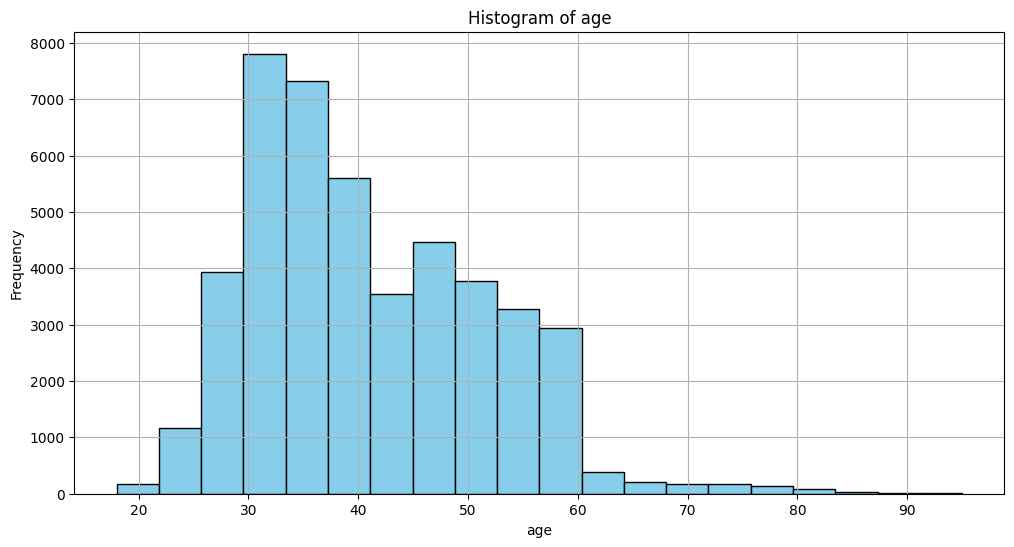

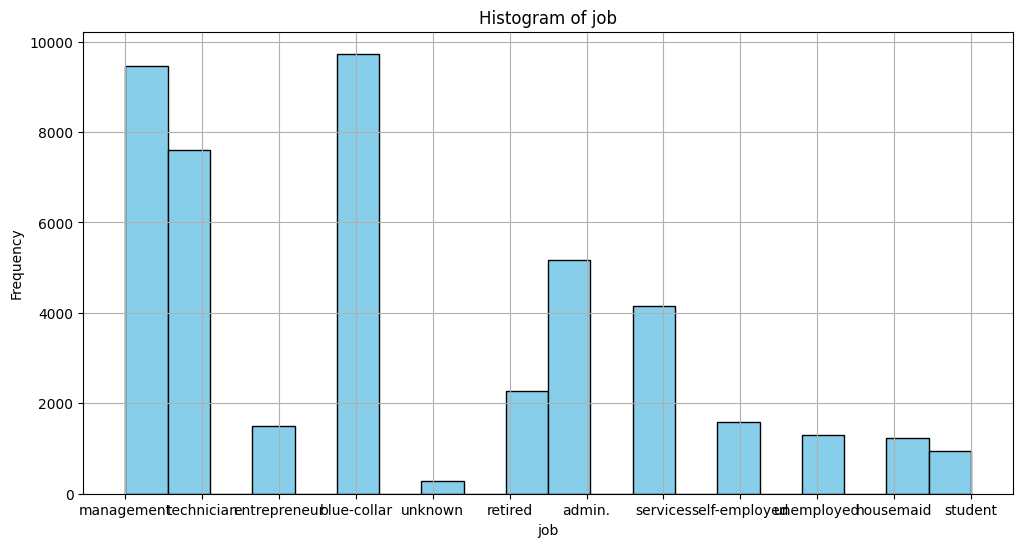

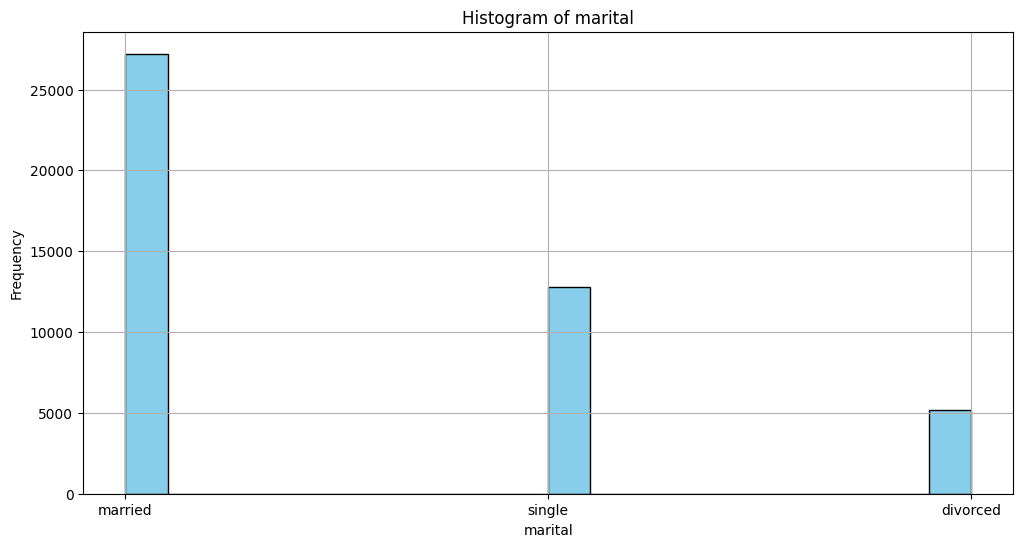

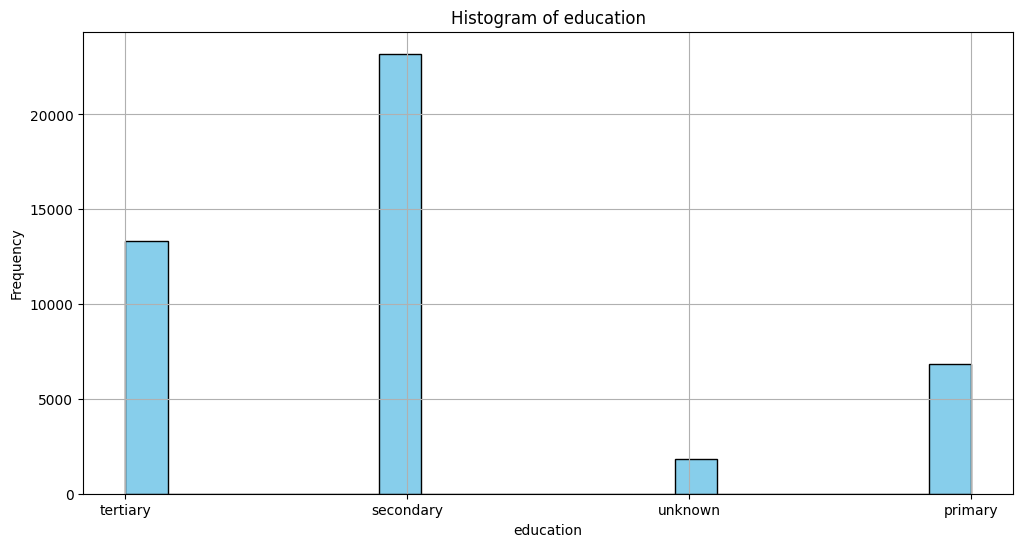

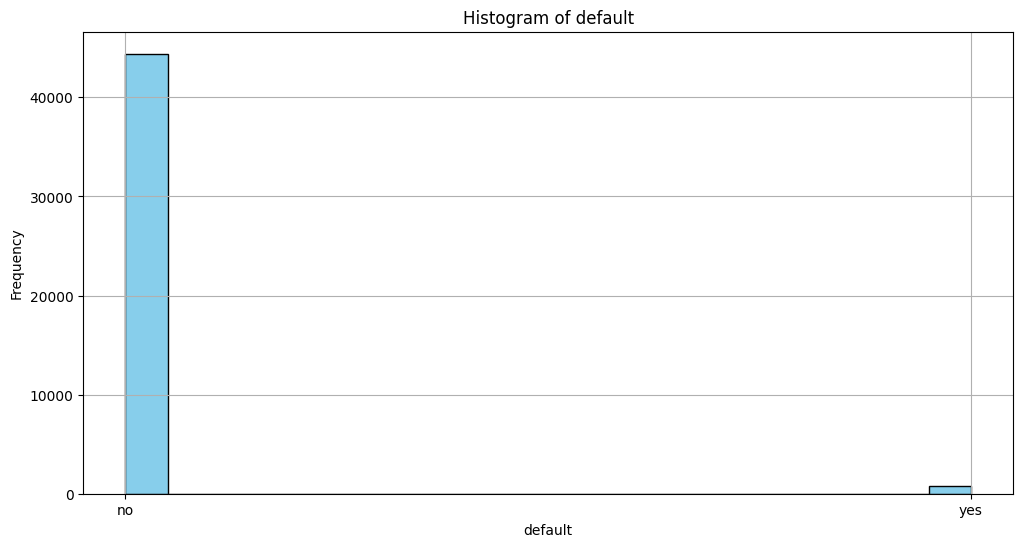

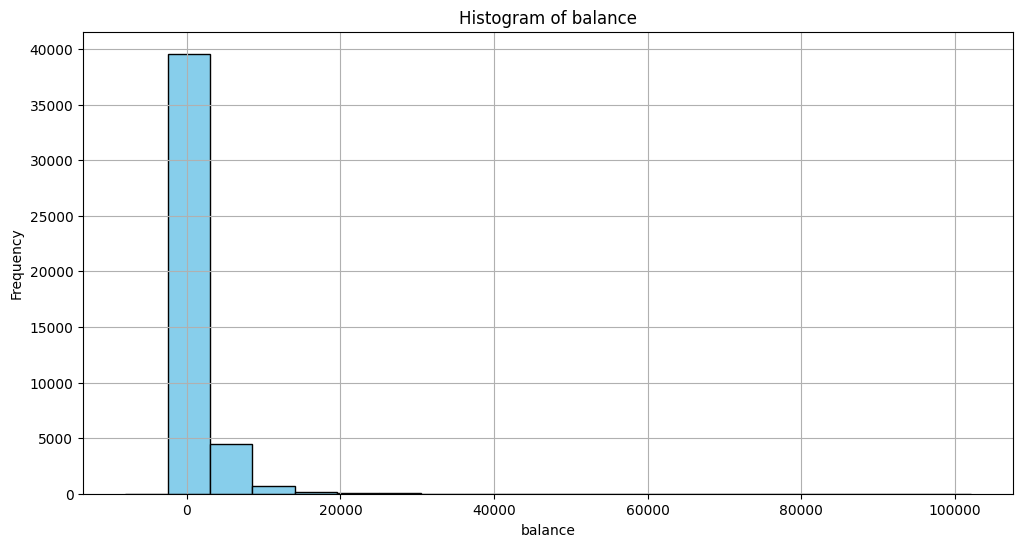

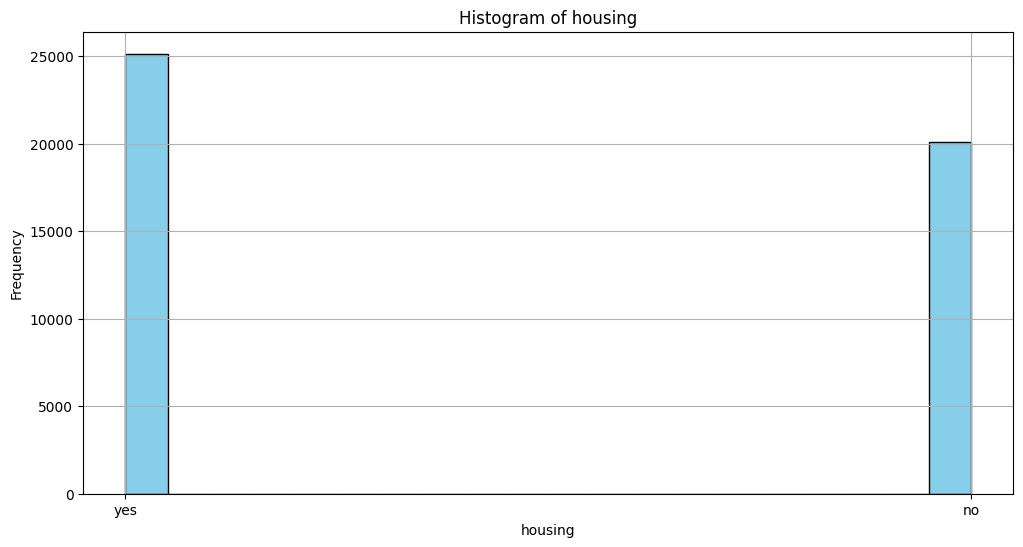

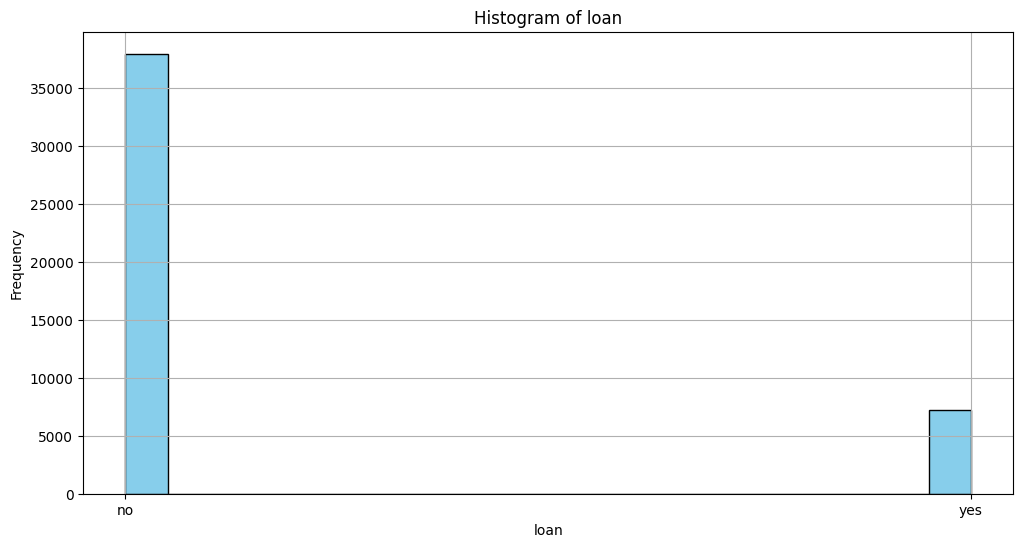

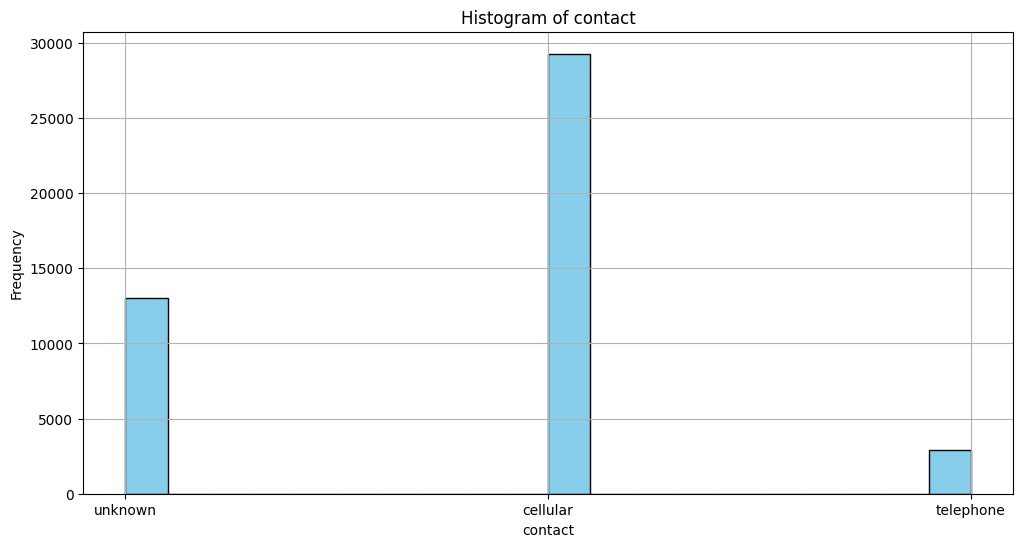

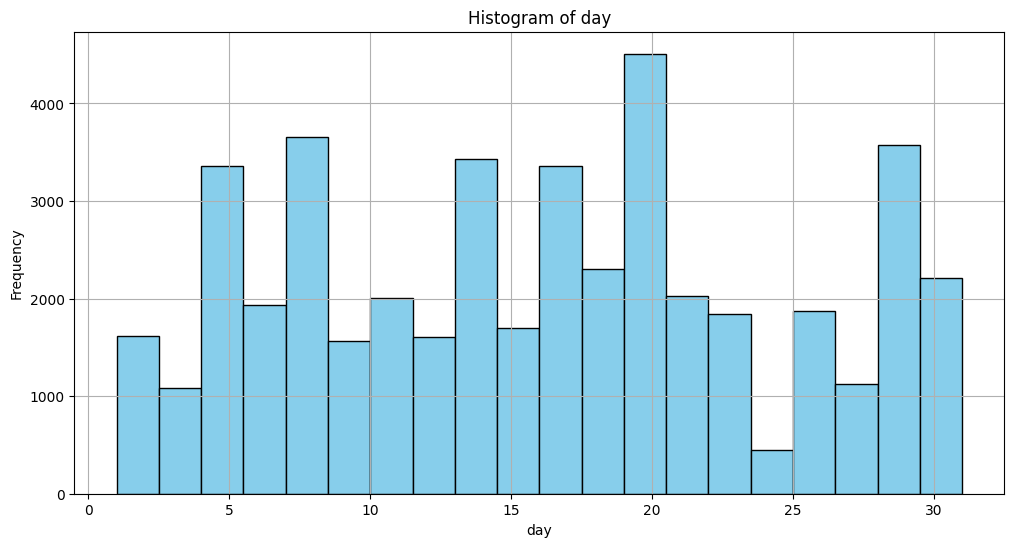

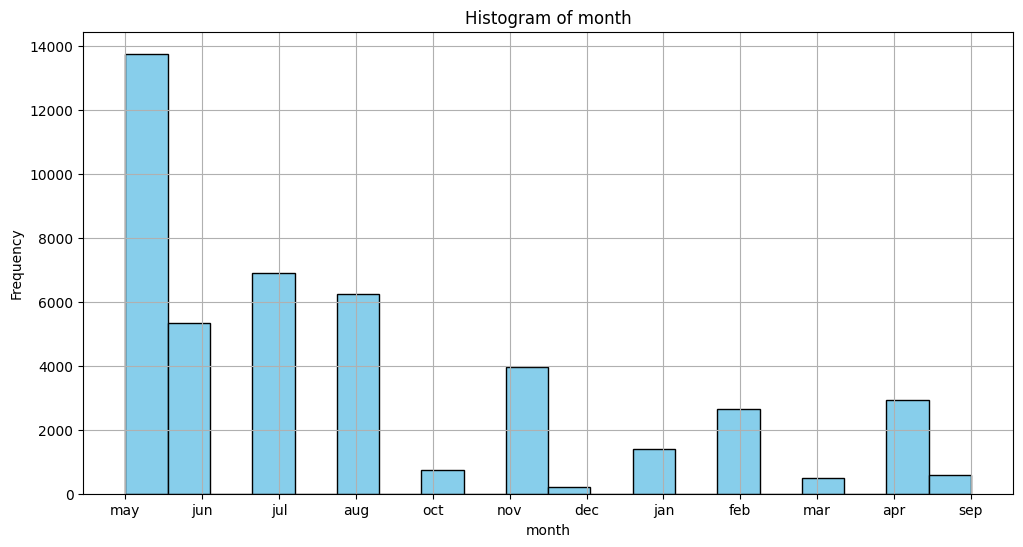

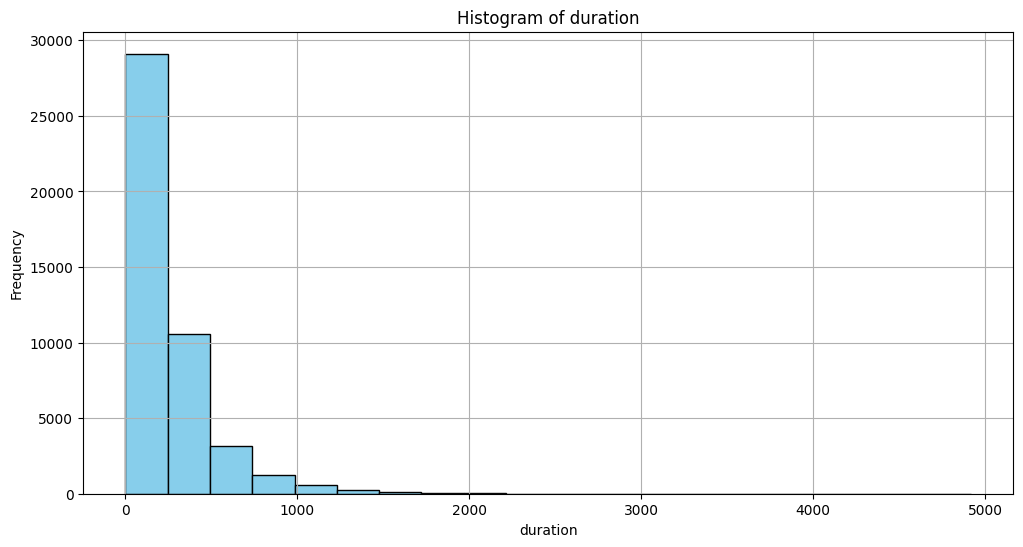

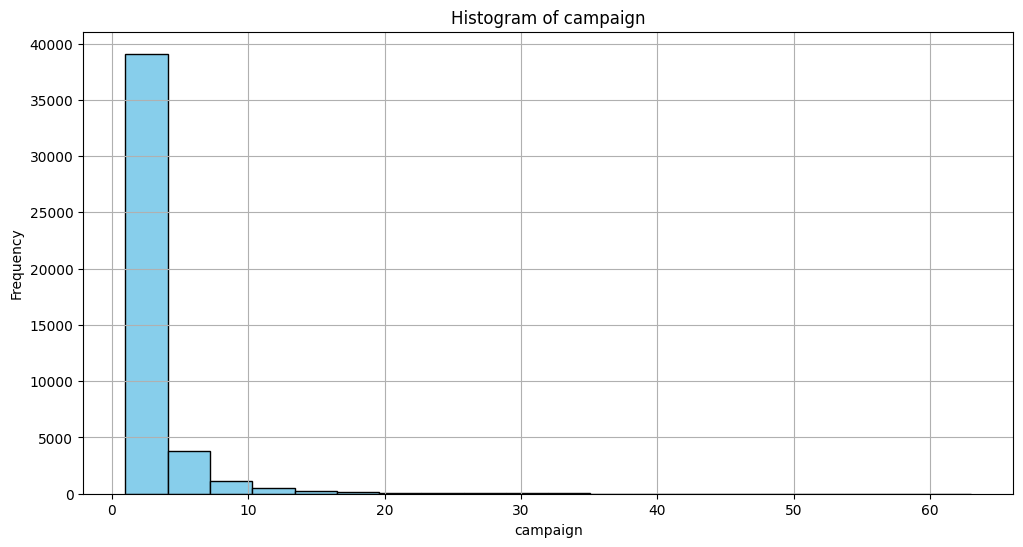

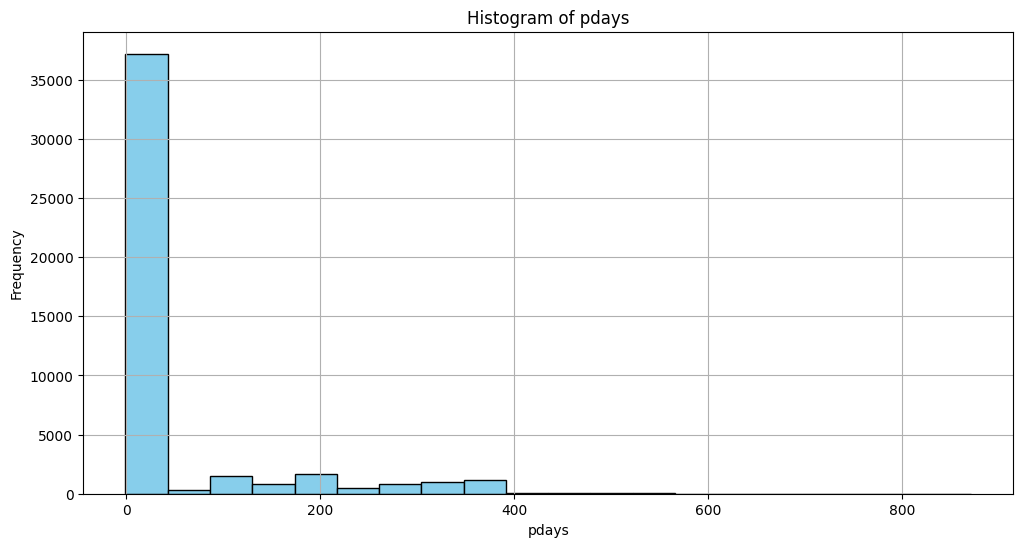

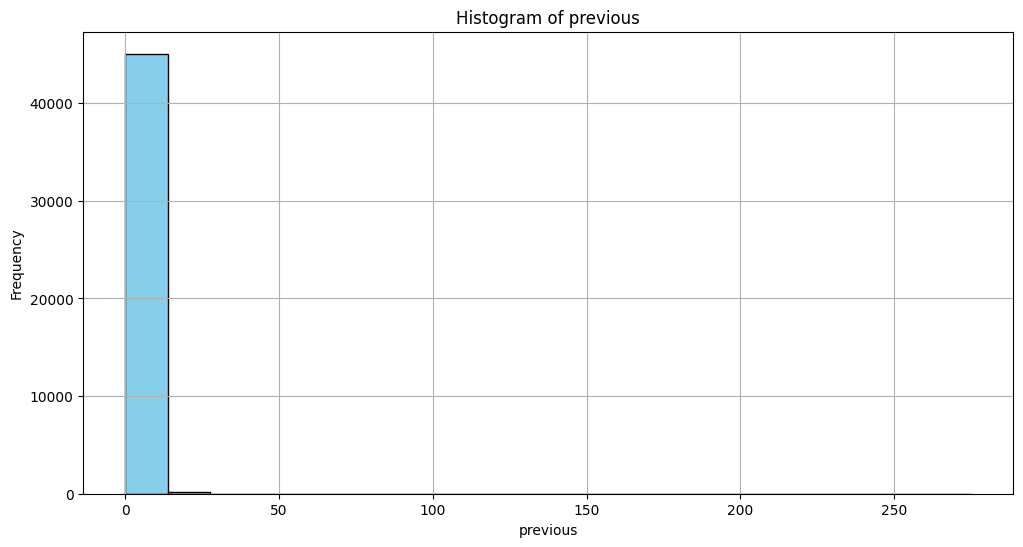

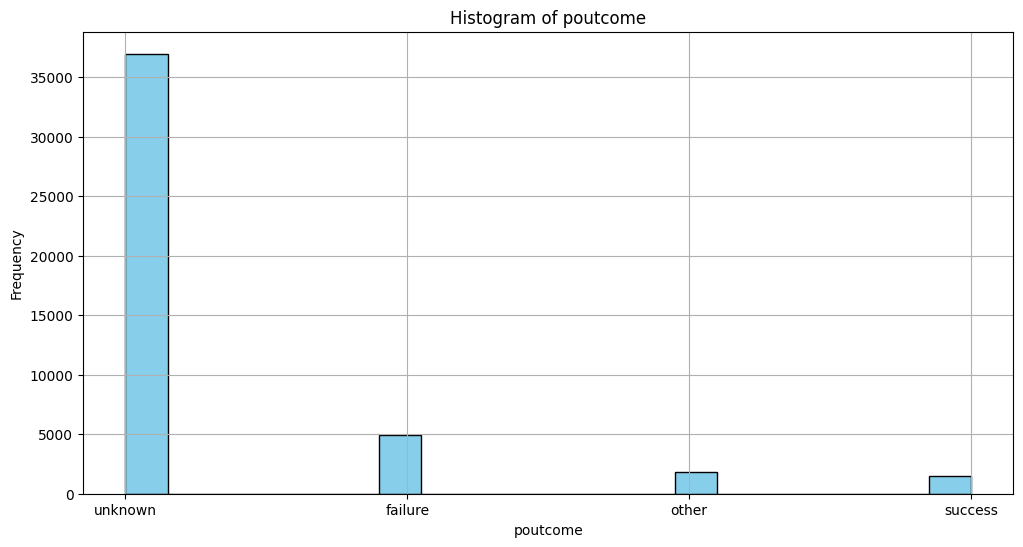

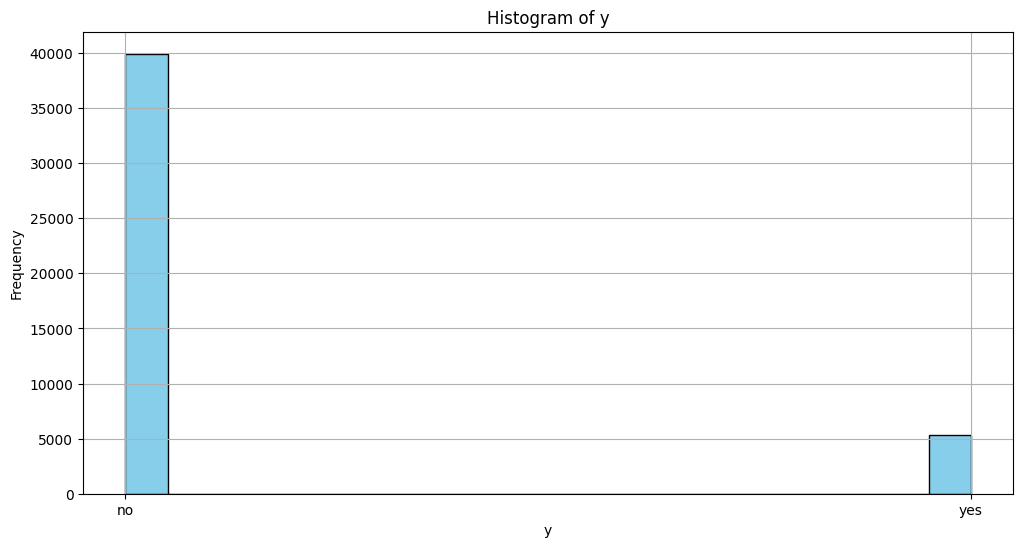

In [9]:
import matplotlib.pyplot as plt

# generate a histogram for all columns in the dataframe
for column in df.columns:
    plt.figure(figsize=(12, 6))  # Set the size of the figure
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')  # Plot histogram
    plt.title(f'Histogram of {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label
    plt.grid(True)  # Add grid

plt.show()  # Show histogram

## Create functions to easily apply encoding methods, avoiding repetitions

In [10]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import numpy as np

def find_delta(df, feature):
    """Find the delta of a data range"""
    return abs(df[feature].max() - df[feature].min())

def calculate_bins_with_freedman_diaconis(df, feature):
    """Use Freedman-Diaconis rule to find optimal number of bins, for data with large samples"""
    q75, q25 = np.percentile(df[feature], [75, 25]) # find Inter-quartile range (IQR)
    iqr = q75 - q25
    delta = abs(df[feature].max() - df[feature].min()) # find delta a.k.a difference

    if delta != 0:
        bins = int(2 * iqr/delta**(1/3)) # apply Freedman-Diaconis Rule
    else:
        bins = 1
        
    return bins

def apply_one_hot_encoding(input_df, output_df, feature):
    one_hot_encoder = OneHotEncoder()

    # fit and transform the data, then convert the resulting sparse matrix to a DF
    one_hot_encoded = one_hot_encoder.fit_transform(input_df[[feature]])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out([feature]))

    # concatenate the one-hot encoded DataFrame with the original DataFrame
    output_df = pd.concat([output_df, one_hot_encoded_df], axis=1)
    return output_df

def apply_ordinal_encoding(input_df, output_df, feature, order):
    ord_encoder = OrdinalEncoder(categories=[order])
    output_df[feature] = ord_encoder.fit_transform(input_df[[feature]])
    return output_df

def process_pdays(input_df):
    output_df = input_df.copy()

    # create the new column
    output_df['contacted'] = (output_df["pdays"] != -1).astype(int)

    # replace -1 with 999
    output_df['pdays'] = output_df['pdays'].replace(-1, 999)
    
    return output_df    

#def apply_label_encoding(input_df, output_df, feature):
#    output_df['education'] = LabelEncoder().fit_transform(input_df[feature])
#    return output_df

## Encode each column based on the nature of the data
### - Data with natural order -> Ordinal Encoder  
### - Data with no natural order | Binary data -> One Hot Encoding  
### - Numerical Data -> Binning | use as-is  

In [11]:
# create a new df for encoded data
encoded_df = pd.DataFrame()

# encode age data through binning method ========================================================
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=50000)
encoded_df[['age']] = discretizer.fit_transform(df[['age']])

# encode job ====================================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'job')

# encode marital ================================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'marital')

# encode education ==============================================================================
edu_order = ['unknown', 'primary', 'secondary', 'tertiary']
encoded_df = apply_ordinal_encoding(df, encoded_df, 'education', edu_order)

# encode default ================================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'default')

# encode balance ================================================================================
bal_bins = calculate_bins_with_freedman_diaconis(df, 'balance')
discretizer = KBinsDiscretizer(n_bins=bal_bins, encode='ordinal', strategy='uniform', subsample=50000)
encoded_df[['balance']] = discretizer.fit_transform(df[['balance']])

# encode housing ================================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'housing')

# encode loan ===================================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'loan')

# encode contact ================================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'contact')

# encode day ====================================================================================
day_bins = calculate_bins_with_freedman_diaconis(df, 'day')
discretizer = KBinsDiscretizer(n_bins=day_bins, encode='ordinal', strategy='uniform', subsample=50000)
encoded_df[['day']] = discretizer.fit_transform(df[['day']])

# encode month ==================================================================================
months_order = ['jan', 'feb', 'mar', 'apr',  
                'may', 'jun', 'jul', 'aug',
                'sep', 'oct', 'nov', 'dec']
encoded_df = apply_ordinal_encoding(df, encoded_df, 'month', months_order)

# encode duration ===============================================================================
dur_bins = calculate_bins_with_freedman_diaconis(df, 'duration')
discretizer = KBinsDiscretizer(n_bins=dur_bins, encode='ordinal', strategy='uniform', subsample=50000)
encoded_df[['duration']] = discretizer.fit_transform(df[['duration']])

# encode campaign ===============================================================================
discretizer = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform', subsample=50000)
encoded_df[['campaign']] = discretizer.fit_transform(df[['campaign']])

# encode pdays ==================================================================================
# This data is interesting because we will:
# 1. create a new column 'contacted' to store info whether or not the person's been contacted before
# 2. replace -1 with 999 to make it linear and in the positive range, but still far enough from the rest of the dataset
encoded_df['pdays'] = process_pdays(df)

# encode previous ===============================================================================
encoded_df['previous'] = df['previous']

# encode poutcome ===============================================================================
encoded_df = apply_one_hot_encoding(df, encoded_df, 'poutcome')

# display encoded df
encoded_df


,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,day,month,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,4.0,1.0,0.0,-1,0,0.0,0.0,0.0,1.0
1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,-1,0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,-1,0,0.0,0.0,0.0,1.0
3,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,-1,0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,1.0,0.0,-1,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,10.0,4.0,0.0,-1,0,0.0,0.0,0.0,1.0
45207,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,10.0,2.0,0.0,-1,0,0.0,0.0,0.0,1.0
45208,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,10.0,5.0,1.0,184,3,0.0,0.0,1.0,0.0
45209,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,10.0,2.0,1.0,-1,0,0.0,0.0,0.0,1.0


In [12]:
filtered_rows = encoded_df[encoded_df['balance'] < 100]

# Print the first row that meets the condition
print(filtered_rows.index[2])

display(df.iloc[filtered_rows.index[0]])
display(encoded_df.iloc[filtered_rows.index[0]])

2


age                  58
job          management
marital         married
education      tertiary
default              no
balance            2143
housing             yes
loan                 no
contact         unknown
day                   5
month               may
duration            261
campaign              1
pdays                -1
previous              0
poutcome        unknown
y                    no
Name: 0, dtype: object

age                  5.0
job_admin.           0.0
job_blue-collar      0.0
job_entrepreneur     0.0
job_housemaid        0.0
job_management       1.0
job_retired          0.0
job_self-employed    0.0
job_services         0.0
job_student          0.0
job_technician       0.0
job_unemployed       0.0
job_unknown          0.0
marital_divorced     0.0
marital_married      1.0
marital_single       0.0
education            3.0
default_no           1.0
default_yes          0.0
balance              5.0
housing_no           0.0
housing_yes          1.0
loan_no              1.0
loan_yes             0.0
contact_cellular     0.0
contact_telephone    0.0
contact_unknown      1.0
day                  1.0
month                4.0
duration             1.0
campaign             0.0
pdays               -1.0
previous             0.0
poutcome_failure     0.0
poutcome_other       0.0
poutcome_success     0.0
poutcome_unknown     1.0
Name: 0, dtype: float64

## Define and train RandomForest model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# define independent (X) and dependent (y) variables
X = encoded_df
y = df['y'] 

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

# define classifier, fit the data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=7)
rf_classifier.fit(X_train, y_train)

# make prediction
y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          no       0.93      0.97      0.95     12030
         yes       0.60      0.39      0.48      1534

    accuracy                           0.90     13564
   macro avg       0.76      0.68      0.71     13564
weighted avg       0.89      0.90      0.89     13564



## Model analysis: Very poor performance on 'yes' class
The model above is able to predict the 'no' class very well. However, it is especially bad to preidct the 'yes' class as depicted by the F1-score. Below 50% indicates that the model performs close to or worse than guessing randomly. 

## Reason: Data imbalance
As depicted in the histogram above, there are significantly more 'no' observations than 'yes' ones; In fact, the ratio is 8:1. This demonstrates how having visual representation of the data may be very helpful.

## Solution: Oversampling
A solution to address data imblanace is to increase the number of the minority (oversampling) or reduce the number of majority (undersampling). The issue of undersampling is that we'd throw away valuable data (information loss) which may impact the model's ability to generalise to real life data, this is not an issue with oversampling. With this consideration in mind, we can use oversampling.


## Re-train, this time using oversampling

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# define independent (X) and dependent (y) variables
X = encoded_df
y = df['y'] 

## use SMOTE to oversample the 'yes' class of the dependent variable
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=7)

# define classifier, fit the data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=7)
rf_classifier.fit(X_train, y_train)

# make prediction
y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          no       0.94      0.95      0.95     11971
         yes       0.95      0.94      0.95     11983

    accuracy                           0.95     23954
   macro avg       0.95      0.95      0.95     23954
weighted avg       0.95      0.95      0.95     23954



## Model Analysis: Satisfactory performance
All metrics scored 94% or above which is satisfactory for our case. We can now export the model.

## Exporting model

In [24]:
import joblib 

joblib.dump(rf_classifier, "./Models/BankMarketing_randomForest_n100.joblib")

['./Models/BankMarketing_randomForest_n100.joblib']

## Try loading and quick test

In [25]:
import joblib

# load the model
try:
    model = joblib.load('./Models/BankMarketing_randomForest_n100.joblib')
except Exception as err:
    print(err)

# test using the same test as before, it should perform identically
test = model.predict(X_test)
print(classification_report(y_test, test))



              precision    recall  f1-score   support

          no       0.94      0.95      0.95     11971
         yes       0.95      0.94      0.95     11983

    accuracy                           0.95     23954
   macro avg       0.95      0.95      0.95     23954
weighted avg       0.95      0.95      0.95     23954



## The model is exported, loadable and ready to be used!